**idea: combine rf regressor (for short term trends) and lstm(for long term trends)**

In [41]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt 
import numpy as np

In [42]:
path = r'C:\Users\User\dev\training_model\dataset\modified_financial_data.csv'
df = pd.read_csv(path)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

df.columns

Index(['^GSPC', 'GLD', 'USO', 'SLV', 'EURUSD=X', 'Date'], dtype='object')

In [43]:
df = df.rename(columns={"^GSPC": "SPX", "EURUSD=X": "EUR/USD"})

df.head()

,SPX,GLD,USO,SLV,EUR/USD,Date
0,2058.199951,114.080002,159.119995,15.11,1.208941,2015-01-02
1,2020.579956,115.800003,150.320007,15.50,1.194643,2015-01-05
2,2002.609985,117.120003,144.399994,15.83,1.193902,2015-01-06
3,2025.900024,116.430000,146.960007,15.85,1.187536,2015-01-07
4,2062.139893,115.940002,148.399994,15.64,1.183600,2015-01-08


In [44]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD']  
target = 'GLD'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

df_scaled = pd.DataFrame(X, columns=features)
df_scaled[target] = y

In [45]:
split_index = int(len(X) * 0.8)
X_train_rf, X_test_rf = X[:split_index], X[split_index:]
y_train_rf, y_test_rf = y[:split_index], y[split_index:]
# features = ['SPX', 'USO', 'SLV', 'EUR/USD']  
# target = 'GLD'

# # Split before scaling to avoid data leakage
# split_index = int(len(df) * 0.8)
# X_train_raw = df[features].iloc[:split_index]
# X_test_raw = df[features].iloc[split_index:]
# y_train_raw = df[[target]].iloc[:split_index]
# y_test_raw = df[[target]].iloc[split_index:]

# # Initialize scalers
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # Fit on training data only
# X_train_rf = scaler_X.fit_transform(X_train_raw)
# X_test_rf = scaler_X.transform(X_test_raw)

# y_train_rf = scaler_y.fit_transform(y_train_raw)
# y_test_rf = scaler_y.transform(y_test_raw)

rf = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
rf.fit(X_train_rf, y_train_rf.ravel())

rf_preds = rf.predict(X_test_rf)

c:\Users\User\dev\training_model\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [46]:
def create_sequences(data, target_column, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

In [47]:
n_steps = 10
lstm_data = df_scaled.copy()
X_lstm, y_lstm = create_sequences(lstm_data, target, n_steps)

X_train_lstm, X_test_lstm = X_lstm[:split_index - n_steps], X_lstm[split_index - n_steps:]
y_train_lstm, y_test_lstm = y_lstm[:split_index - n_steps], y_lstm[split_index - n_steps:]

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=0)

lstm_preds = model_lstm.predict(X_test_lstm)

c:\Users\User\dev\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [48]:
min_len = min(len(rf_preds), len(lstm_preds))
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]
y_true = y_test_rf[-min_len:]


combined_preds = (0.25 * rf_preds) + (0.75 * lstm_preds)
combined_preds = combined_preds.ravel()
y_true = y_true.ravel()

In [49]:
meta_X = np.column_stack((rf_preds, lstm_preds.ravel()))
meta_y = y_true

meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
final_preds = meta_model.predict(meta_X)

In [57]:
y_true = y_true.ravel()
rf_preds = rf_preds.ravel()
lstm_preds = lstm_preds.ravel()

# Align by minimum length
min_len = min(len(y_true), len(rf_preds), len(lstm_preds))
y_true = y_true[-min_len:]
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]

# Weighted ensemble
combined_preds = (0.25 * rf_preds) + (0.75 * lstm_preds)

# Evaluate
print("R² Score (Ensemble):", r2_score(y_true, combined_preds))
print("MSE (Ensemble):", mean_squared_error(y_true, combined_preds))


R² Score (Ensemble): 0.8076549089821248
MSE (Ensemble): 0.004973047394351365


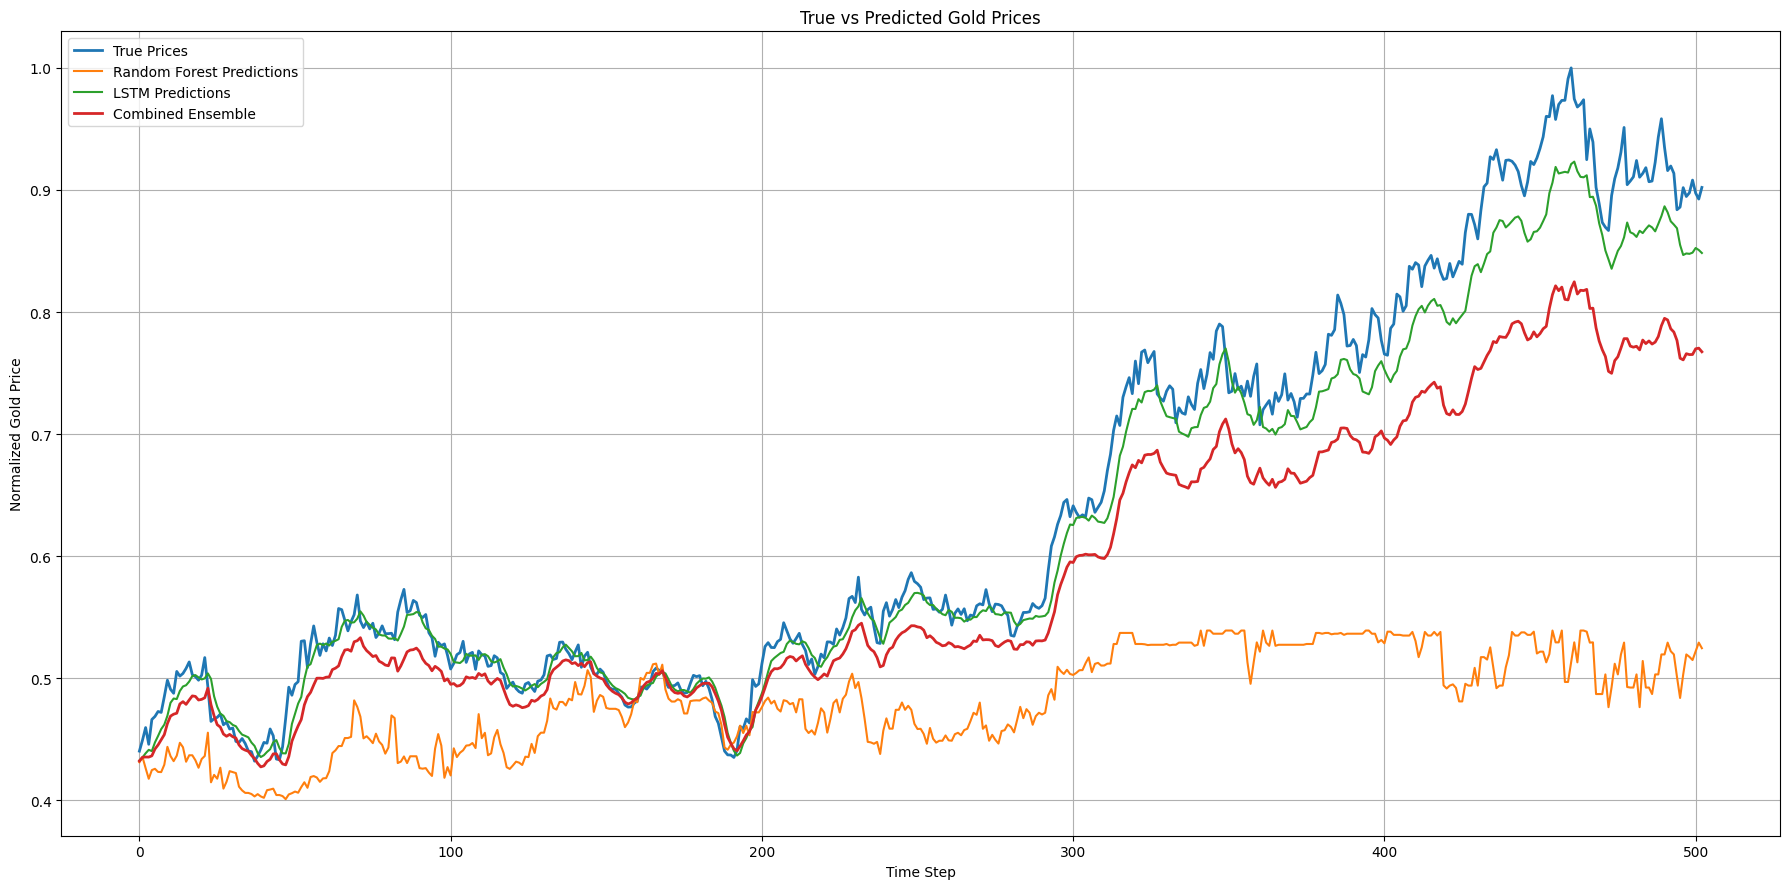

In [58]:
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='True Prices', linewidth=2)
plt.plot(rf_preds, label='Random Forest Predictions')
plt.plot(lstm_preds, label='LSTM Predictions')
plt.plot(combined_preds, label='Combined Ensemble', linewidth=2)

plt.title('True vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

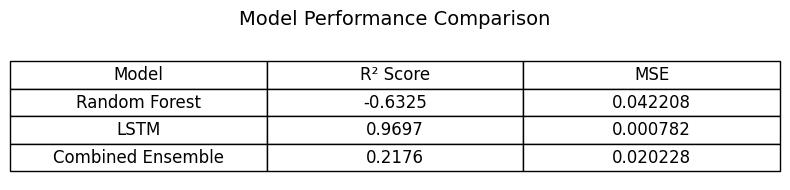

In [52]:
metrics = {
    'Model': ['Random Forest', 'LSTM', 'Combined Ensemble'],
    'R² Score': [
        round(r2_score(y_true, rf_preds), 4),
        round(r2_score(y_true, lstm_preds), 4),
        round(r2_score(y_true, combined_preds), 4)
    ],
    'MSE': [
        round(mean_squared_error(y_true, rf_preds), 6),
        round(mean_squared_error(y_true, lstm_preds), 6),
        round(mean_squared_error(y_true, combined_preds), 6)
    ]
}


fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')  

table_data = [metrics['Model'], metrics['R² Score'], metrics['MSE']]
table_data = list(zip(*table_data))  

table = ax.table(
    cellText=table_data,
    colLabels=["Model", "R² Score", "MSE"],
    cellLoc='center',
    loc='center'
)

table.scale(1, 2)
table.set_fontsize(12)
plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [53]:
def find_best_values(y_true, rf_preds, lstm_preds):
   
    y_true = y_true.ravel()
    rf_preds = rf_preds.ravel()
    lstm_preds = lstm_preds.ravel()

    
    min_len = min(len(y_true), len(rf_preds), len(lstm_preds))
    y_true = y_true[-min_len:]
    rf_preds = rf_preds[-min_len:]
    lstm_preds = lstm_preds[-min_len:]

    best_r2 = -np.inf
    best_mse = np.inf
    best_weight = None

    print(f"{'Weight (LSTM)':<15} {'R² Score':<10} {'MSE':<10}")

    for w in np.linspace(0, 1, 101):  
        combined_preds = (1 - w) * rf_preds + w * lstm_preds
        r2 = r2_score(y_true, combined_preds)
        mse = mean_squared_error(y_true, combined_preds)

        print(f"{w:<15.2f} {r2:<10.4f} {mse:<10.6f}")

        
        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_weight = w

    print("\n🔍 Best LSTM weight:")
    print(f"Weight: {best_weight:.2f}")
    print(f"R² Score: {best_r2:.4f}")
    print(f"MSE: {best_mse:.6f}")

    return best_weight, best_r2, best_mse


In [54]:
best_weight, best_r2, best_mse = find_best_values(y_true, rf_preds, lstm_preds)

Weight (LSTM)   R² Score   MSE       
0.00            -0.6325    0.042208  
0.01            -0.6039    0.041468  
0.02            -0.5755    0.040735  
0.03            -0.5474    0.040008  
0.04            -0.5196    0.039288  
0.05            -0.4920    0.038575  
0.06            -0.4646    0.037868  
0.07            -0.4375    0.037167  
0.08            -0.4107    0.036473  
0.09            -0.3841    0.035786  
0.10            -0.3578    0.035106  
0.11            -0.3317    0.034432  
0.12            -0.3059    0.033764  
0.13            -0.2804    0.033103  
0.14            -0.2550    0.032449  
0.15            -0.2300    0.031801  
0.16            -0.2052    0.031160  
0.17            -0.1807    0.030526  
0.18            -0.1564    0.029898  
0.19            -0.1323    0.029276  
0.20            -0.1085    0.028661  
0.21            -0.0850    0.028053  
0.22            -0.0617    0.027451  
0.23            -0.0387    0.026856  
0.24            -0.0160    0.026268  
0.25        

In [55]:
#--- as we can se the r2 score is not going after 0.7-0.25  spliiting of weights of lstm-rfr weight distribution.

**gpt method(fixing data leakages)**

c:\Users\User\dev\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


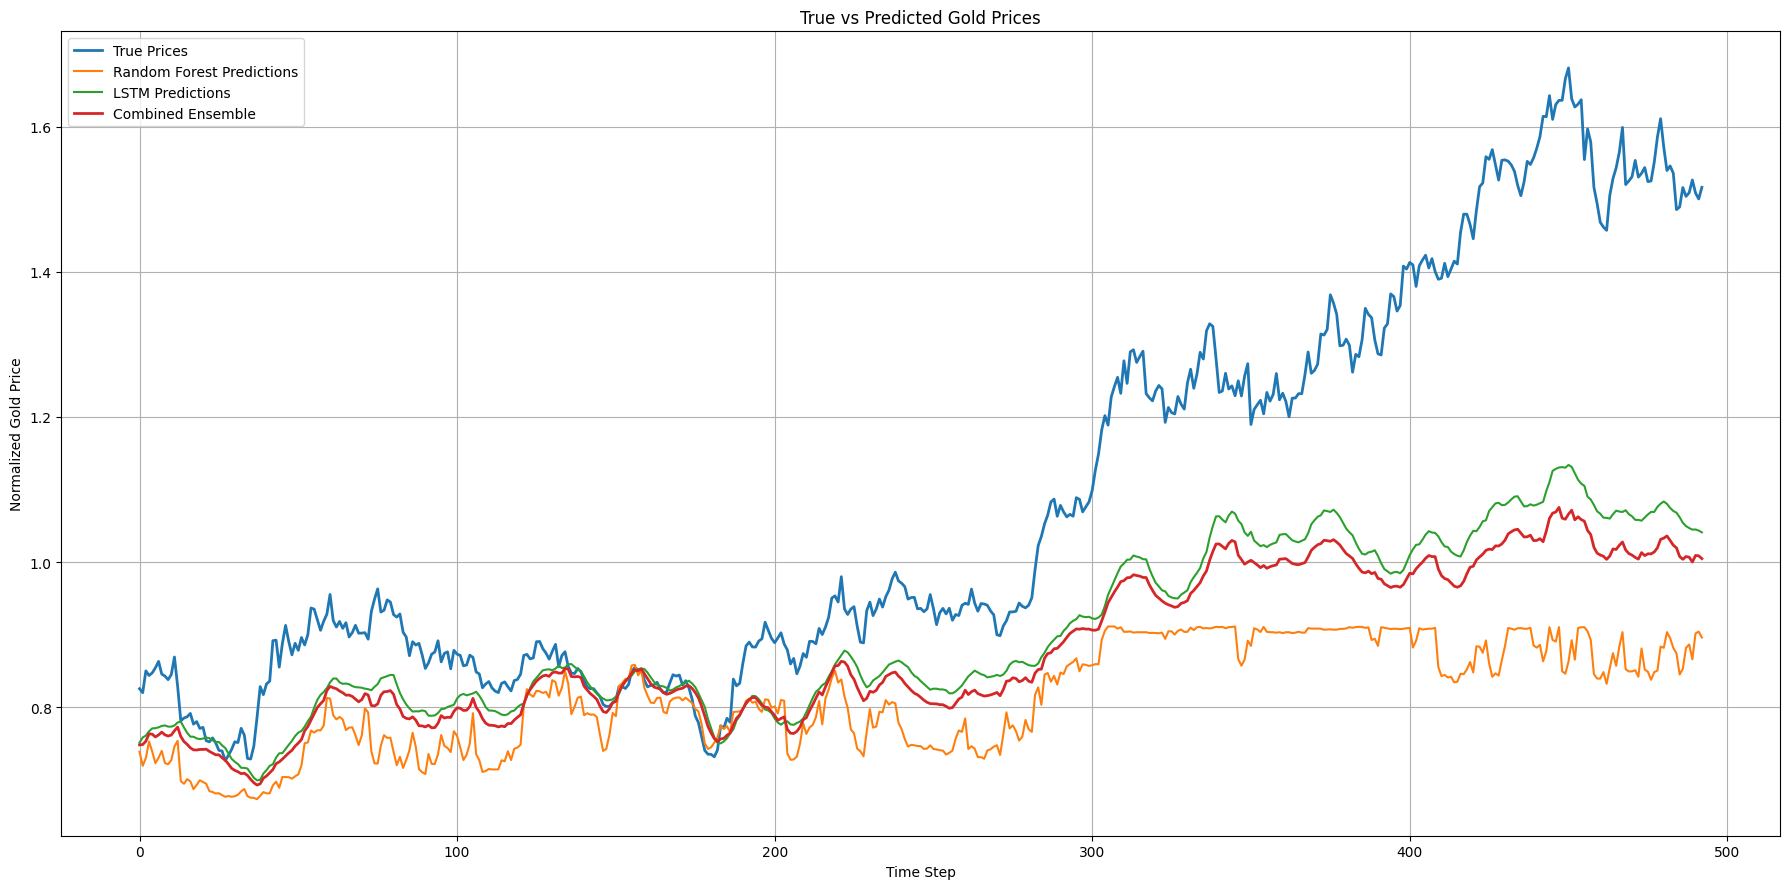

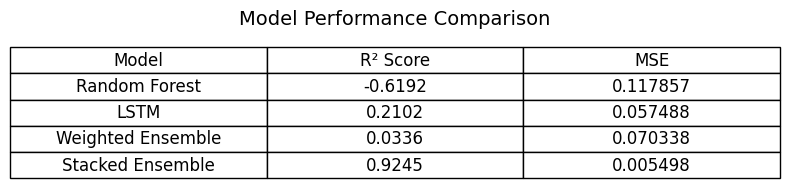

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load and prepare data
df = pd.read_csv(r'C:\Users\User\dev\training_model\dataset\modified_financial_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.rename(columns={"^GSPC": "SPX", "EURUSD=X": "EUR/USD"}, inplace=True)

# Features and target
features = ['SPX', 'USO', 'SLV', 'EUR/USD']
target = 'GLD'

# Train-test split index (time series safe)
split_index = int(len(df) * 0.8)
train_df, test_df = df.iloc[:split_index], df.iloc[split_index:]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_test = scaler_X.transform(test_df[features])

y_train = scaler_y.fit_transform(train_df[[target]])
y_test = scaler_y.transform(test_df[[target]])

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
rf_preds = rf.predict(X_test)

# --- Sequence Generator ---
def create_sequences(df_seq, features, target_col, n_steps, scaler_X, scaler_y):
    data_scaled = df_seq.copy()
    X_scaled = scaler_X.transform(data_scaled[features])
    y_scaled = scaler_y.transform(data_scaled[[target_col]])

    X_seq, y_seq = [], []
    for i in range(n_steps, len(data_scaled)):
        X_seq.append(X_scaled[i - n_steps:i])
        y_seq.append(y_scaled[i])
    return np.array(X_seq), np.array(y_seq)

# Prepare data for LSTM (use only training data for fitting)
n_steps = 10
X_lstm_train, y_lstm_train = create_sequences(train_df, features, target, n_steps, scaler_X, scaler_y)
X_lstm_test, y_lstm_test = create_sequences(test_df, features, target, n_steps, scaler_X, scaler_y)

# LSTM Model
model_lstm = Sequential([
    LSTM(50, input_shape=(n_steps, len(features))),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=16, verbose=0)

lstm_preds = model_lstm.predict(X_lstm_test).ravel()

# Align lengths for evaluation
min_len = min(len(rf_preds), len(lstm_preds))
rf_preds = rf_preds[-min_len:]
lstm_preds = lstm_preds[-min_len:]
y_true = y_test[-min_len:].ravel()

# Weighted Ensemble
combined_preds = 0.25 * rf_preds + 0.75 * lstm_preds

# Stacking Ensemble (trained only on test predictions here for demonstration)
meta_X = np.column_stack((rf_preds, lstm_preds))
meta_model = LinearRegression()
meta_model.fit(meta_X, y_true)
final_preds = meta_model.predict(meta_X)

# Evaluation Metrics
def evaluate_model(name, y_true, preds):
    return {
        'Model': name,
        'R² Score': round(r2_score(y_true, preds), 4),
        'MSE': round(mean_squared_error(y_true, preds), 6)
    }

metrics = [
    evaluate_model("Random Forest", y_true, rf_preds),
    evaluate_model("LSTM", y_true, lstm_preds),
    evaluate_model("Weighted Ensemble", y_true, combined_preds),
    evaluate_model("Stacked Ensemble", y_true, final_preds)
]

# --- Plot Results ---
plt.figure(figsize=(18, 9))
plt.plot(y_true, label='True Prices', linewidth=2)
plt.plot(rf_preds, label='Random Forest Predictions')
plt.plot(lstm_preds, label='LSTM Predictions')
plt.plot(combined_preds, label='Combined Ensemble', linewidth=2)
plt.title('True vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Table of Results ---
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table_data = [(m['Model'], m['R² Score'], m['MSE']) for m in metrics]
table = ax.table(cellText=table_data, colLabels=["Model", "R² Score", "MSE"],
                 cellLoc='center', loc='center')
table.scale(1, 2)
table.set_fontsize(12)
plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.tight_layout()
plt.show()
